In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier


In [2]:
#reading the cleaned dataset
df = pd.read_csv('train_cleaned.csv')
df.head()

,Type,Name,Age,Breed1,Breed2,Breed2_new,Gender,Color1,Color2,Color3,...,Group,Fee,State,RescuerID,VideoAmt,Description,Length_Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,0,1,1,7,0,...,0,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,359,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,0,1,1,2,0,...,0,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,118,6296e909a,2.0,0
2,1,Brisco,1,307,0,0,1,2,7,0,...,0,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,"""Their pregnant mother was dumped by her irres...",395,3422e4906,7.0,3
3,1,Miko,4,307,0,0,2,1,2,0,...,0,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"""Good guard dog, very alert, active, obedience...",148,5842f1ff5,8.0,2
4,1,Hunter,1,307,0,0,1,1,0,0,...,0,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,"""This handsome yet cute boy is up for adoption...",392,850a43f90,3.0,2


In [3]:
df.columns

#putting adoption speed last
df = df[['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Breed2_new', 'Gender',
       'Color1', 'Color2', 'Color3', 'Single_Colored', 'Double_Colored',
       'Triple_Colored', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Group', 'Fee', 'State',
       'RescuerID', 'VideoAmt', 'Description', 'Length_Description', 'PetID',
       'PhotoAmt','AdoptionSpeed']]


In [4]:
df['AdoptionSpeed'][df['AdoptionSpeed'] == 0]=1


C:\Users\colla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
#change breed2_new to one if higher than 0, otherwise 0
df['Breed2_new'] = df['Breed2_new'].where(df['Breed2_new'] < 1, other=1)

#keep a copy of the description column if needed later
description = df['Description']

#use this df as starting block for all models and create a copy for the basic model
basic_df = df.copy()
df.to_csv('df.csv')

In [6]:
#looking at types to drop text or irrelevant columns
basic_df.dtypes

Type                    int64
Name                   object
Age                     int64
Breed1                  int64
Breed2                  int64
Breed2_new              int64
Gender                  int64
Color1                  int64
Color2                  int64
Color3                  int64
Single_Colored          int64
Double_Colored          int64
Triple_Colored          int64
MaturitySize            int64
FurLength               int64
Vaccinated              int64
Dewormed                int64
Sterilized              int64
Health                  int64
Quantity                int64
Group                   int64
Fee                     int64
State                   int64
RescuerID              object
VideoAmt                int64
Description            object
Length_Description      int64
PetID                  object
PhotoAmt              float64
AdoptionSpeed           int64
dtype: object

In [7]:
basic_df = basic_df.drop(['Description','RescuerID','PetID','Name'], axis=1)

In [8]:
#checking if any null value
basic_df.columns[basic_df.isna().any()].tolist()

[]

In [9]:
#creating X and y arrays for modelling
array_basic = basic_df.values
X_basic = array_basic[:, 0:-1]
y_basic = array_basic[:, -1]

In [10]:
#running a function which evaluates accuracy for various models

def evaluate_classifiers(X, y, n_splits=4, shuffle=True, random_state=0):
    
    num_trees=100
    num_features=3
    seed= 0
    
    features = [('Normal',       X)]
    
    models = [('LogisticRegression',         LogisticRegression(solver="liblinear")),
              ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
              ('KNeighborsClassifier',       KNeighborsClassifier()),
              ('Naive Bayes',                GaussianNB()),
              ('DecisionTreeClassifier',     DecisionTreeClassifier()),
              ('SupportVectorMachine',       SVC(gamma="scale")),
              ('DecisionTree',               DecisionTreeClassifier(random_state=seed)),
              ('RandomForest',               RandomForestClassifier(n_estimators=num_trees, max_features=num_features, random_state=seed)),
              ('XGBoost',                    xgb.XGBClassifier())]    
    
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    results = []
    for model in models:
        
        for feature in features:
            res = cross_val_score(model[1], feature[1], y, cv=kfold)
            
            [results.append((model[0], feature[0], model[0]+'_'+feature[0], r)) for r in res]
    
    results = pd.DataFrame(results, columns=['Model', 'FeatureScaling', 'Combined', 'Result'])
    return results

In [11]:
#return results
results_basic = evaluate_classifiers(X_basic,y_basic)
accuracy_basic = results_basic.groupby(['Combined'],sort=False).mean().reset_index()
accuracy_basic

C:\Users\colla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\colla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\colla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\colla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\colla\Anaconda3\lib\site-pa

,Combined,Result
0,LogisticRegression_Normal,0.330732
1,LinearDiscriminantAnalysis_Normal,0.360816
2,KNeighborsClassifier_Normal,0.319792
3,Naive Bayes_Normal,0.348342
4,DecisionTreeClassifier_Normal,0.351745
5,SupportVectorMachine_Normal,0.279968
6,DecisionTree_Normal,0.351612
7,RandomForest_Normal,0.418651
8,XGBoost_Normal,0.414848


In [12]:
#package for ensemble
from sklearn.ensemble import VotingClassifier

resall=pd.DataFrame()
res_w1=pd.DataFrame()

num_trees=100
num_features=3
seed=0

estimators=[]

#model 1 = xgboost
model1=xgb.XGBClassifier()
estimators.append(("xgb", model1))

#model 2 = random forest
model2=RandomForestClassifier(n_estimators=num_trees, max_features=num_features, random_state=seed)
estimators.append(("rf", model2))

model=VotingClassifier(estimators)

kfold=KFold(n_splits=10, random_state=seed)

results=cross_val_score(model, X_basic, y_basic, cv=kfold)

print(f'Voting Ensemble (xgb,rf) - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

res_w1["Res"]=results
res_w1["Type"]="Voting"

resall=pd.concat([resall,res_w1], ignore_index=True)

Voting Ensemble (xgb,rf) - Accuracy 41.331% std 0.907983


In [13]:
feat_imp = pd.DataFrame(columns = ['name', 'xgb_importance','rf_importance'])

#xgb and rf models
model_rf=RandomForestClassifier(n_estimators=num_trees, max_features=num_features, random_state=seed)
model_rf.fit(X_basic,y_basic)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_basic,y_basic)

#calculating xgb and rf feature importance then adding them to total column
for name, importance, importances in zip(basic_df.columns, xgb_model.feature_importances_, model_rf.feature_importances_):
    feat_imp = feat_imp.append({'name':name, 'xgb_importance':importance, 'rf_importance':importances}, ignore_index = True)
    feat_imp['total'] = feat_imp['xgb_importance']+ feat_imp['rf_importance']
    feat_imp = feat_imp.sort_values('total',ascending=False)
    
feat_imp

,name,xgb_importance,rf_importance,total
0,Age,0.126846,0.108858,0.235703
1,Length_Description,0.026495,0.165077,0.191571
24,PhotoAmt,0.065333,0.107137,0.172470
2,Breed1,0.098764,0.062282,0.161047
3,Sterilized,0.076701,0.028887,0.105588
4,Breed2_new,0.083765,0.012361,0.096126
5,State,0.040423,0.051910,0.092333
6,Color1,0.028798,0.060994,0.089792
7,Quantity,0.061401,0.025590,0.086991
8,FurLength,0.045713,0.036225,0.081938


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_basic, y_basic, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_basic, y_basic)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 44.61%


Confusion matrix:
 [[306 209  40 126]
 [193 334  57 230]
 [137 170 137 226]
 [ 86 148  39 561]]


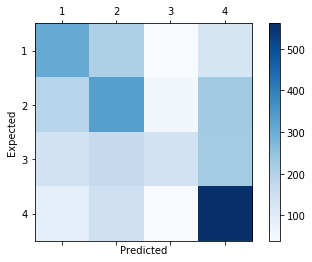

In [17]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['1', '2','3', '4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [26]:
# Class count
count_class_1, count_class_2, count_class_3, count_class_4 = basic_df.AdoptionSpeed.value_counts()

# Divide by class
df_class_1 = basic_df[basic_df['AdoptionSpeed'] == 1]
df_class_2 = basic_df[basic_df['AdoptionSpeed'] == 2]
df_class_3 = basic_df[basic_df['AdoptionSpeed'] == 3]
df_class_4 = basic_df[basic_df['AdoptionSpeed'] == 4]

In [36]:
basic_df.AdoptionSpeed.value_counts()

4    4197
2    4037
1    3499
3    3258
Name: AdoptionSpeed, dtype: int64

Random under-sampling:
4    4197
3    4197
2    4197
1    4197
Name: AdoptionSpeed, dtype: int64


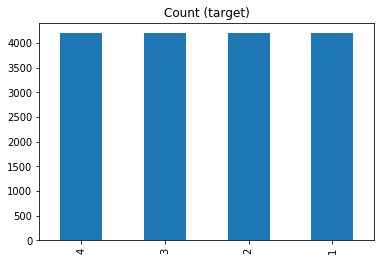

In [45]:
df_class_1_under = df_class_1.sample(count_class_1, replace=True)
df_class_2_under = df_class_2.sample(count_class_1, replace=True)
df_class_3_under = df_class_3.sample(count_class_1, replace=True)

df_test_under = pd.concat([df_class_1_under, df_class_2_under, df_class_3_under, df_class_4], axis=0)

print('Random under-sampling:')
print(df_test_under.AdoptionSpeed.value_counts())

df_test_under.AdoptionSpeed.value_counts().plot(kind='bar', title='Count (target)');

In [46]:
df_test_under

,Type,Age,Breed1,Breed2,Breed2_new,Gender,Color1,Color2,Color3,Single_Colored,...,Sterilized,Health,Quantity,Group,Fee,State,VideoAmt,Length_Description,PhotoAmt,AdoptionSpeed
13639,2,1,265,285,1,3,1,6,7,0,...,2,1,3,1,150,41326,0,93,8.0,1
6046,2,2,266,256,1,2,2,0,0,1,...,2,1,3,1,0,41326,0,440,5.0,1
1791,1,36,109,307,1,2,3,5,0,0,...,2,1,2,1,0,41401,0,552,2.0,1
7754,2,1,265,0,0,2,1,0,0,1,...,2,1,1,0,0,41326,0,170,1.0,1
3734,2,2,303,266,1,2,1,3,0,0,...,2,1,1,0,0,41401,0,161,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14978,1,24,307,307,0,2,2,0,0,1,...,3,1,1,0,0,41326,0,239,1.0,4
14982,1,60,307,0,0,2,2,5,0,0,...,3,1,1,0,0,41324,0,23,1.0,4
14983,1,24,179,307,1,1,2,3,7,0,...,2,1,1,0,0,41326,0,62,0.0,4
14987,2,60,265,264,1,3,1,4,7,0,...,1,1,2,1,0,41326,0,172,3.0,4


In [47]:
#creating X and y arrays for modelling
array_basic2 = df_test_under.values
X_basic2 = array_basic2[:, 0:-1]
y_basic2 = array_basic2[:, -1]

In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_basic2, y_basic2, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_basic2, y_basic2)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 48.03%


Confusion matrix:
 [[512 121  76 132]
 [265 249 144 181]
 [178 140 310 195]
 [136  97  80 542]]


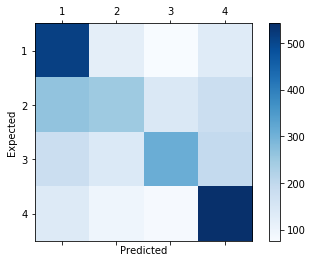

In [49]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['1', '2','3', '4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Random under-sampling:
4    3258
3    3258
2    3258
1    3258
Name: AdoptionSpeed, dtype: int64


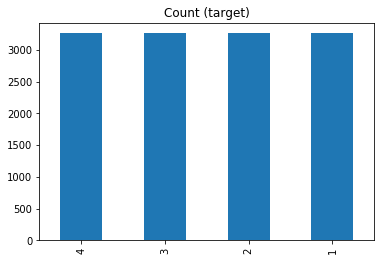

In [50]:
df_class_1_under2 = df_class_1.sample(count_class_4)
df_class_2_under2 = df_class_2.sample(count_class_4)
df_class_3_under2 = df_class_4.sample(count_class_4)

df_test_under = pd.concat([df_class_1_under2, df_class_2_under2, df_class_3_under2, df_class_3], axis=0)

print('Random under-sampling:')
print(df_test_under.AdoptionSpeed.value_counts())

df_test_under.AdoptionSpeed.value_counts().plot(kind='bar', title='Count (target)');

In [51]:
array_basic2 = df_test_under.values
X_basic2 = array_basic2[:, 0:-1]
y_basic2 = array_basic2[:, -1]

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_basic2, y_basic2, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_basic2, y_basic2)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 44.92%


Confusion matrix:
 [[383  90  69 128]
 [215 168 111 141]
 [165  94 220 161]
 [106  90  66 400]]


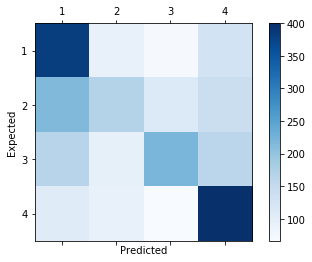

In [53]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['1', '2','3', '4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()